In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor

# classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import lightgbm as lgb

# for results
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

pd.set_option("display.max_rows", 10)

In [18]:
# import DNN & initial setting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [5]:
# load data
division = 'm'  # s or m (s = small-sized meeting room, m = medium-sized seminar room)

# session 1
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess1\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess1\S=*.csv')
l.sort()

df_fea_sess1 = []
for i in l:
    df_fea_sess1.append(pd.read_csv(i, header=None))

# session 2
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess2\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess2\S=*.csv')
l.sort()

df_fea_sess2 = []
for i in l:
    df_fea_sess2.append(pd.read_csv(i, header=None))
    
# session 3
if division == 's':
    l = glob.glob(r'..\..\datasets\small-room\sess3\S=*.csv')
elif division == 'm':
    l = glob.glob(r'..\..\datasets\medium-room\sess3\S=*.csv')
l.sort()

df_fea_sess3 = []
for i in l:
    df_fea_sess3.append(pd.read_csv(i, header=None))

In [6]:
l

['..\\..\\datasets\\medium-room\\sess3\\S=0.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=1.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=2.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=3.csv',
 '..\\..\\datasets\\medium-room\\sess3\\S=4.csv']

In [8]:
# select session (sess1, sess2, sess3)

df_fea = df_fea_sess1

In [9]:
df_fea[0].shape

(399, 356)

In [10]:
# create column label (feature name)
# l(N1)_xxx(N2) >> N1: link number, N2: subcarrier number.

nof_link = 4
nof_usedsubc = 13

col_label = []

for i in range(nof_link):
    
    for j in range(nof_usedsubc):
        col_label.append('l%d_std%d' %(i+1,j+1))
        col_label.append('l%d_min%d' %(i+1,j+1))
        col_label.append('l%d_max%d' %(i+1,j+1))
        col_label.append('l%d_qtl%d' %(i+1,j+1))
        col_label.append('l%d_qtu%d' %(i+1,j+1))
        col_label.append('l%d_avg%d' %(i+1,j+1))
        
    for j in range(6):
        col_label.append('l%d_cur%d' %(i+1,j+1))
    for j in range(5):
        col_label.append('l%d_der%d' %(i+1,j+1))    

len(col_label)

356

In [11]:
# change column label

for i in range(len(df_fea)):
    df_fea[i].columns = col_label

In [12]:
df_fea[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur2,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,0.000003,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,0.000027,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,0.000040,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,0.000018,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.000001,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2.234998,1.952983,1.642235,1.552838,1.686878,2.188347,2.466221,2.025162,1.933353,1.760320,...,0.000023,-0.001875,0.049112,-0.179824,10.048577,-3.035061e-07,0.000090,-0.005625,0.098223,-0.179824
395,2.136482,2.112427,1.756895,1.640038,1.605874,2.040877,2.245979,1.822832,1.856636,1.732509,...,0.000012,-0.001043,0.020199,0.219921,8.553810,-3.865501e-08,0.000048,-0.003129,0.040398,0.219921
396,2.320379,2.269228,1.839009,1.702551,1.535080,1.516574,1.428790,1.220235,1.294640,1.203857,...,0.000050,-0.003108,0.070145,-0.218774,8.743192,-1.336387e-06,0.000199,-0.009325,0.140289,-0.218774
397,2.107777,1.920989,1.682704,1.690026,1.659764,1.700245,1.649740,1.328510,1.216458,1.217324,...,0.000069,-0.004302,0.102801,-0.535439,8.660696,-1.910258e-06,0.000275,-0.012905,0.205601,-0.535439


In [13]:
# Ground truth

for i in range(len(df_fea)):
    df_fea[i]['S'] = i

In [14]:
df_fea[0]

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,S
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2.234998,1.952983,1.642235,1.552838,1.686878,2.188347,2.466221,2.025162,1.933353,1.760320,...,-0.001875,0.049112,-0.179824,10.048577,-3.035061e-07,0.000090,-0.005625,0.098223,-0.179824,0
395,2.136482,2.112427,1.756895,1.640038,1.605874,2.040877,2.245979,1.822832,1.856636,1.732509,...,-0.001043,0.020199,0.219921,8.553810,-3.865501e-08,0.000048,-0.003129,0.040398,0.219921,0
396,2.320379,2.269228,1.839009,1.702551,1.535080,1.516574,1.428790,1.220235,1.294640,1.203857,...,-0.003108,0.070145,-0.218774,8.743192,-1.336387e-06,0.000199,-0.009325,0.140289,-0.218774,0
397,2.107777,1.920989,1.682704,1.690026,1.659764,1.700245,1.649740,1.328510,1.216458,1.217324,...,-0.004302,0.102801,-0.535439,8.660696,-1.910258e-06,0.000275,-0.012905,0.205601,-0.535439,0


In [15]:
df_fea_all = pd.DataFrame()

for i in range(len(df_fea)):
    df_fea_all = pd.concat([df_fea_all, df_fea[i]], axis=0)

df_fea_all.reset_index(drop=True)

,l1_std1,l1_min1,l1_max1,l1_qtl1,l1_qtu1,l1_avg1,l1_std2,l1_min2,l1_max2,l1_qtl2,...,l4_cur3,l4_cur4,l4_cur5,l4_cur6,l4_der1,l4_der2,l4_der3,l4_der4,l4_der5,S
0,1.461229,1.403337,1.329958,1.183326,1.083925,1.030910,1.060135,0.948225,0.944712,0.878323,...,-0.001783,0.071555,-0.451787,9.110630,8.476972e-07,0.000011,-0.005350,0.143110,-0.451787,0
1,1.206355,1.028218,0.993922,0.874931,0.872215,0.911993,0.961354,0.854425,0.843202,0.776964,...,-0.002552,0.079066,-0.526390,10.690206,-2.650281e-07,0.000107,-0.007657,0.158133,-0.526390,0
2,0.747694,0.706687,0.675697,0.677832,0.596699,0.656809,0.696858,0.723022,0.759360,0.710899,...,-0.003094,0.087967,-0.587742,10.941266,-7.766324e-07,0.000158,-0.009282,0.175934,-0.587742,0
3,0.680562,0.652428,0.617645,0.655980,0.595589,0.618400,0.705216,0.705249,0.719335,0.599678,...,-0.002280,0.079904,-0.622525,10.893866,1.265775e-07,0.000071,-0.006841,0.159808,-0.622525,0
4,1.418847,1.444397,1.328114,1.280205,1.189202,1.207989,1.236722,1.037668,1.032366,0.900402,...,-0.001523,0.069126,-0.568937,10.664818,9.074015e-07,-0.000005,-0.004569,0.138252,-0.568937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,0.917898,0.919850,0.856698,0.804004,0.727550,0.679315,0.650399,0.645671,0.707827,0.656676,...,0.000444,0.015425,-0.062696,10.424669,1.781041e-06,-0.000127,0.001333,0.030851,-0.062696,4
1991,0.993171,1.055292,0.918394,0.886796,0.840524,0.783448,0.783273,0.697142,0.768202,0.650290,...,0.001289,-0.000815,-0.047433,10.910980,2.140359e-06,-0.000183,0.003866,-0.001630,-0.047433,4
1992,0.913375,1.006806,1.072936,1.082991,1.013199,0.927840,0.883479,0.827988,0.818503,0.758421,...,0.000557,0.027969,-0.485448,11.351925,1.960868e-06,-0.000151,0.001671,0.055939,-0.485448,4
1993,0.987489,1.093021,1.092624,1.122730,1.011742,0.943294,0.923651,0.845975,0.821050,0.787015,...,0.000407,0.029154,-0.436101,10.818459,2.029731e-06,-0.000146,0.001221,0.058308,-0.436101,4


In [16]:
# set k for k-hold cross-validation
k = 7
skf = StratifiedKFold(n_splits=k)

X = df_fea_all.drop('S', axis=1)
y = df_fea_all['S']

X = X.reset_index()
X = X.drop('index', axis = 1)
y = y.reset_index()
y = y.drop('index', axis = 1)

train_index = [[] for _ in range(k)]
test_index = [[] for _ in range(k)]

n = 0
for tra_idx, tes_idx in skf.split(X,y):
    
    print('##### Stratified k-fold',n+1,'回目 #####')
    print("TRAIN: ",len(tra_idx))
    print("TEST: ",len(tes_idx))
    
    train_index[n] = tra_idx
    test_index[n] = tes_idx
    
    n += 1

##### Stratified k-fold 1 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 2 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 3 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 4 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 5 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 6 回目 #####
TRAIN:  1710
TEST:  285
##### Stratified k-fold 7 回目 #####
TRAIN:  1710
TEST:  285


In [21]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

In [19]:
y_hot = to_categorical(y)
y_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

2022-02-14 15:56:59.004548
Epoch 1/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.5560 - accuracy: 0.7446 - val_loss: 0.1153 - val_accuracy: 0.9766
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9948 - val_loss: 0.0363 - val_accuracy: 0.9825
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.0161 - val_accuracy: 0.9883
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9883
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 8.4932e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9942
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 4.3277e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9942
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 1.9597e-04 - accuracy: 1.0000 - val_lo

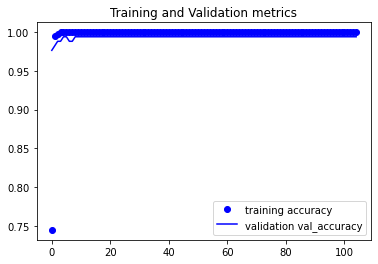

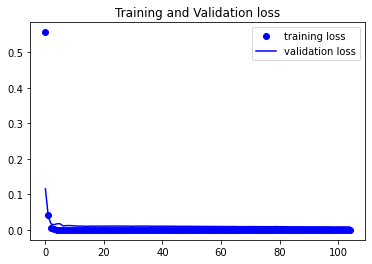

Epoch 1/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.7197 - accuracy: 0.6348 - val_loss: 0.3475 - val_accuracy: 0.7778
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.3749 - accuracy: 0.7648 - val_loss: 0.2889 - val_accuracy: 0.7778
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.2460 - accuracy: 0.8389 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0736 - accuracy: 0.9844 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9903 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.0286 - val_accuracy: 0.9883
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9955 - val_loss: 0.0132 - val_accuracy: 0.9942
Epoch

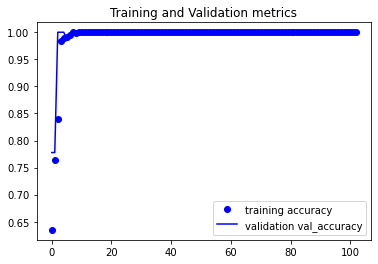

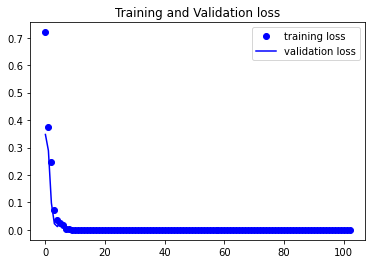

Epoch 1/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.4676 - accuracy: 0.8538 - val_loss: 0.1525 - val_accuracy: 0.9532
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.1057 - accuracy: 0.9630 - val_loss: 0.0256 - val_accuracy: 0.9883
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9870 - val_loss: 0.0192 - val_accuracy: 0.9883
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9909 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0108 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch

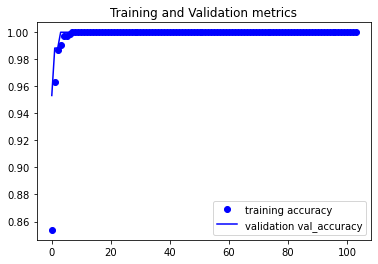

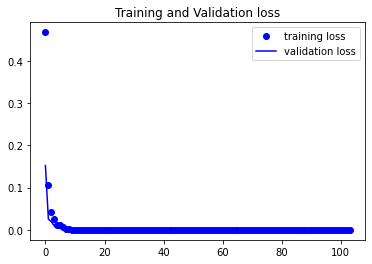

Epoch 1/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.4703 - accuracy: 0.7999 - val_loss: 0.1252 - val_accuracy: 0.9591
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0862 - accuracy: 0.9721 - val_loss: 0.0477 - val_accuracy: 0.9825
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.0275 - val_accuracy: 0.9825
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0190 - accuracy: 0.9929 - val_loss: 0.0242 - val_accuracy: 0.9942
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0193 - val_accuracy: 0.9942
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0124 - accuracy: 0.9955 - val_loss: 0.0214 - val_accuracy: 0.9942
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9942
Epoch

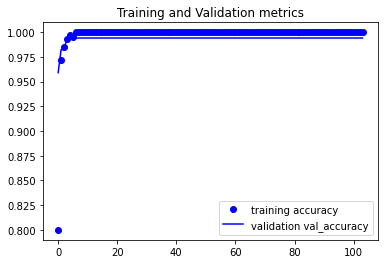

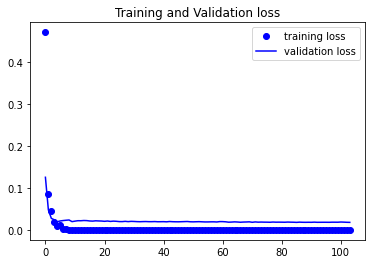

Epoch 1/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.6187 - accuracy: 0.7212 - val_loss: 0.3357 - val_accuracy: 0.7895
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.3516 - accuracy: 0.7856 - val_loss: 0.3548 - val_accuracy: 0.7778
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.3521 - accuracy: 0.7875 - val_loss: 0.2902 - val_accuracy: 0.7895
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.2961 - accuracy: 0.7895 - val_loss: 0.2952 - val_accuracy: 0.7778
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.2473 - accuracy: 0.7947 - val_loss: 0.2157 - val_accuracy: 0.7953
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.1774 - accuracy: 0.8655 - val_loss: 0.1212 - val_accuracy: 0.9942
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0576 - accuracy: 0.9981 - val_loss: 0.0185 - val_accuracy: 0.9942
Epoch

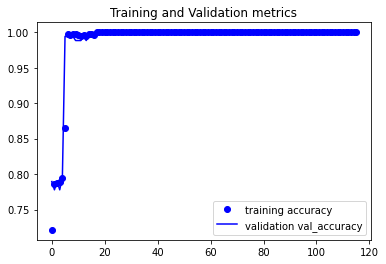

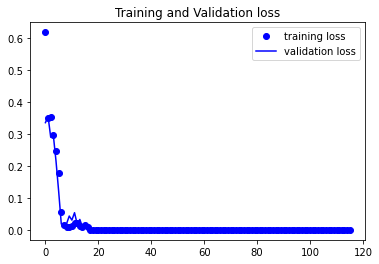

Epoch 1/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.6267 - accuracy: 0.7557 - val_loss: 0.1159 - val_accuracy: 0.9591
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0885 - accuracy: 0.9727 - val_loss: 0.0362 - val_accuracy: 0.9883
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.9792 - val_loss: 0.0339 - val_accuracy: 0.9825
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0083 - val_accuracy: 0.9942
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0150 - accuracy: 0.9961 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch

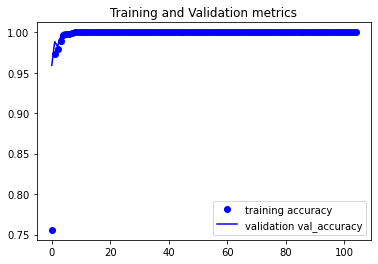

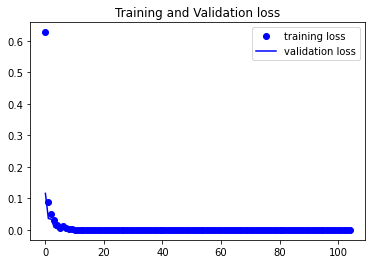

Epoch 1/1000
16/16 [==============================] - 1s 13ms/step - loss: 0.4438 - accuracy: 0.8616 - val_loss: 0.1363 - val_accuracy: 0.9532
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0791 - accuracy: 0.9708 - val_loss: 0.0397 - val_accuracy: 0.9766
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9870 - val_loss: 0.0378 - val_accuracy: 0.9766
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0234 - val_accuracy: 0.9942
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0245 - val_accuracy: 0.9883
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0188 - val_accuracy: 0.9942
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.0190 - val_accuracy: 0.9942
Epoch

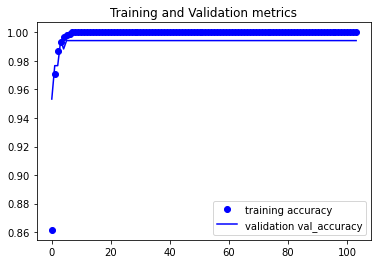

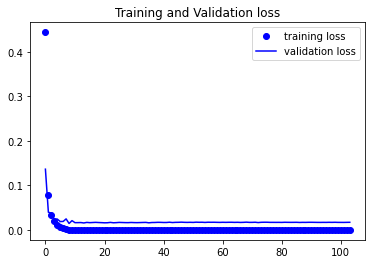

2022-02-14 15:58:20.822845


In [22]:
# learning

y_test_list = [[] for _ in range(k)]
y_pred_list = [[] for _ in range(k)]

print(datetime.datetime.now())

for i in range(k):
    
    X_train = X.iloc[train_index[i]]
    X_test = X.iloc[test_index[i]]
    y_train = y.iloc[train_index[i]]
    y_test = y.iloc[test_index[i]]
    
    # valdation data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)
    
    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    X_test = pd.DataFrame(X_test)
    
    y_train_hot = to_categorical(y_train)
    y_val_hot = to_categorical(y_val)
    
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt,  
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # fit
    history = model.fit(X_train, y_train_hot,  
                        batch_size=100, 
                        epochs=1000,      
                        verbose=1,       
                        validation_data=(X_val, y_val_hot), 
                        callbacks=(early_stopping))
    
    # prediction
    y_pred_hot = model.predict(X_test)
    y_pred = np.argmax(y_pred_hot, axis=1)
    
    y_test_list[i] = y_test
    y_pred_list[i] = y_pred
    
    print(i+1)
    
    compare_TV(history, "accuracy", "val_accuracy")
    
print(datetime.datetime.now())

In [23]:
for i in range(len(y_test_list)):
    y_test_list[i] = y_test_list[i].values

In [24]:
y_test_tot = []
y_pred_tot = []

for i in range(k):
    y_test_tot.extend(y_test_list[i])
    y_pred_tot.extend(y_pred_list[i])

In [25]:
# result scores

print("############## DNN #############")
print("accuracy: ",round(accuracy_score(y_test_tot, y_pred_tot),4))
print(classification_report(y_test_tot, y_pred_tot))
print(confusion_matrix(y_test_tot, y_pred_tot))

############## DNN #############
accuracy:  0.9704
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       399
           1       0.99      0.97      0.98       399
           2       0.98      0.99      0.98       399
           3       0.99      0.94      0.97       399
           4       0.97      0.99      0.98       399

    accuracy                           0.97      1995
   macro avg       0.97      0.97      0.97      1995
weighted avg       0.97      0.97      0.97      1995

[[383   4   6   3   3]
 [  0 389   3   0   7]
 [  5   0 394   0   0]
 [ 21   0   0 376   2]
 [  5   0   0   0 394]]
